In [1]:
import pandas as pd
df=pd.read_csv('Raw_Data_GeneSpring.csv', sep='\t')
df.head(n=10)

,ProbeName,GSM1149106_M_Ns3.txt:gProcessedSignal(normalized),GSM1149107_M_Ns4.txt:gProcessedSignal(normalized),GSM1149108_M_Ns5.txt:gProcessedSignal(normalized),GSM1149109_M_Ns6.txt:gProcessedSignal(normalized),GSM1149110_M_Ns7.txt:gProcessedSignal(normalized),GSM1149111_M_Ns8.txt:gProcessedSignal(normalized),GSM1149112_M_Ns9.txt:gProcessedSignal(normalized),GSM1149113_M_Ns10.txt:gProcessedSignal(normalized),GSM1149114_M_Ns11.txt:gProcessedSignal(normalized),...,GSM1149147_F_Sm6.txt:gProcessedSignal(normalized),GSM1149148_F_Sm7.txt:gProcessedSignal(normalized),GSM1149149_F_Sm8.txt:gProcessedSignal(normalized),GSM1149150_F_Sm9.txt:gProcessedSignal(normalized),GSM1149151_F_Sm10.txt:gProcessedSignal(normalized),GSM1149152_F_Sm11.txt:gProcessedSignal(normalized),GSM1149153_F_Sm12.txt:gProcessedSignal(normalized),GeneSymbol,EntrezGeneID,Go
0,GE_BrightCorner,17.288560,18.103434,18.280110,17.883734,17.879555,17.340961,16.226210,16.203045,15.940904,...,16.039999,15.783204,14.843888,15.553449,15.912829,15.604271,16.120403,NaN,NaN,NaN
1,DarkCorner,2.172766,0.075925,0.232402,0.052573,0.483300,0.240482,0.327676,0.041980,0.015175,...,0.232663,0.023183,0.104347,0.055785,0.141535,0.113465,0.592137,NaN,NaN,NaN
2,A_24_P66027,11.954556,11.681619,11.831579,12.262896,11.233925,11.722222,11.582652,13.039122,12.615288,...,12.446932,12.315217,11.945836,11.924950,13.129469,12.378983,13.259206,APOBEC3B,9582.0,GO:0051607|GO:0047844|GO:0045087|GO:0008152|GO...
3,A_32_P77178,6.224496,6.963845,7.096990,7.319873,6.611215,6.760409,7.810502,8.377619,8.169108,...,7.813999,7.763040,7.712591,7.165884,8.364161,6.885972,9.458718,NaN,NaN,NaN
4,A_23_P212522,9.328137,9.164498,8.934509,9.166321,9.175541,8.810351,10.665818,10.681737,10.359045,...,10.240832,9.757538,9.847317,9.931273,10.160020,10.282162,11.035402,ATP11B,23200.0,GO:0005515|GO:0000287|GO:0005794|GO:0005886|GO...
5,A_24_P934473,6.784073,6.776234,6.684156,6.220987,5.923483,6.219626,8.875294,7.844176,7.824462,...,7.096265,6.978835,6.562293,6.714188,7.573987,6.647150,7.652528,METTL22,79091.0,GO:0008168|GO:0005634|GO:0032259
6,A_24_P9671,11.231391,12.073791,11.931393,12.758203,11.523391,12.085002,13.651166,13.555499,13.658414,...,13.353139,13.437815,12.957280,13.218200,13.584692,12.926903,14.160157,DNAJA1,3301.0,GO:0006986|GO:0005515|GO:0048471|GO:0009408|GO...
7,A_32_P29551,5.627228,5.104215,2.430247,6.246770,3.520792,3.513224,9.173946,4.708292,5.206853,...,6.660863,5.936302,6.653729,7.290971,7.110983,7.394767,4.928184,NaN,NaN,NaN
8,A_24_P801451,7.066391,7.629956,7.423323,6.849318,6.807059,6.654153,7.359266,6.954688,6.706116,...,6.956726,6.344813,6.191489,6.432817,6.877969,6.164639,6.736359,EHMT2,10919.0,GO:0005515|GO:0000790|GO:0016571|GO:0006325|GO...
9,A_32_P30710,14.361890,15.641834,15.269551,15.305865,15.416383,15.264607,16.880970,16.524456,16.657730,...,16.845987,16.234467,16.219038,16.090244,16.317635,16.235386,17.167896,RPL23,9349.0,GO:0005515|GO:0010467|GO:0003735|GO:0019083|GO...


In [2]:
def get_value(category,idx):
    #category def
    #1 male non smoker
    #2 male smoker
    #3 women non smoker
    #4 women smoker
    columns=[]
    if category==1:
        columns=df.columns[1:13]
    elif category==2:
        columns=df.columns[13:25]
    elif category==3:
        columns=df.columns[25:37]
    elif category==4:
        columns=df.columns[37:49]
    return df.iloc[idx][columns].values

In [82]:
import numpy as np
import scipy.stats as stats

def setup_models():
    A=np.zeros((48,4))
    for i in range(4):
        for j in range(12):
            A[j+(i*12),i]=1
            
    A_null=np.zeros((48,4))
    for i in range(4):
        for j in range(12):
            if i==0:
                A_null[j+(i*12),0]=1
                A_null[j+(i*12),1]=1
            elif i==1:
                A_null[j+(i*12),0]=1
                A_null[j+(i*12),2]=1
            elif i==2:
                A_null[j+(i*12),3]=1
                A_null[j+(i*12),1]=1
            elif i==3:
                A_null[j+(i*12),3]=1
                A_null[j+(i*12),2]=1
    return (A,A_null)

def setup_1way_model():
    B=np.zeros((24,2))
    for i in range(2):
        for j in range(12):
            B[j+i*12,i]=1
    B_null=np.zeros((24,1))+1
    return (B,B_null)

def get_sum_sq(A,h):
    k=h.shape[0]
    P=np.matmul(np.transpose(A),A)
    S=np.linalg.pinv(P)
    Inner=np.eye(k)-np.matmul(np.matmul(A,S),np.transpose(A))
    sum_sq=np.matmul(np.matmul(np.transpose(h),Inner),h)
    return sum_sq

def generate_p_value(h,A,A_null):
    denom=get_sum_sq(A,h)
    if denom<1e-8:
        return 1
    A_rank=np.linalg.matrix_rank(A)
    A_null_rank=np.linalg.matrix_rank(A_null)
    F=((get_sum_sq(A_null,h)/denom)-1)*((h.shape[0]-A_rank)/(A_rank-A_null_rank)) #(48-4/4-3)
    p=1-stats.f.cdf(F,A_rank-A_null_rank,h.shape[0]-A_rank)
    return p

# def compute_gene_type(i):
#     #1- down in women
#     #2- up in women
#     #3- down in men
#     #4- up in men
#     data=[]
#     for category in range(1,5):
#         data.append(get_value(category,i))
#     means=[np.mean(x) for x in data]
#     delta_men=means[0]-means[1]
#     delta_women=means[2]-means[3]
#     #if significant_difference_for_male(i):
#     if abs(delta_men)>abs(delta_women):
#         return 3 if delta_men>0 else 4
#     else:
#         return 1 if delta_women>0 else 2
    
# def significant_difference_for_male(i):
#     B,B_null=setup_1way_model()
#     h_male=df.iloc[i][df.columns[1:25]].values
#     h_female=df.iloc[i][df.columns[25:49]].values
#     p_value_anova_male=generate_p_value(h_male,B,B_null)
#     p_value_anova_female=generate_p_value(h_female,B,B_null)
#     if p_value_anova_male<p_value_anova_female:
#         return True 
def compute_gene_type(i):
    #1- down in women
    #2- up in women
    #3- down in men
    #4- up in men
    data=[]
    for category in range(1,5):
        data.append(get_value(category,i))
    means=[np.mean(x) for x in data]
    delta_men=means[0]-means[1]
    delta_women=means[2]-means[3]
    ans=[-1,-1] #-1 denotes no list
    if significant_difference(i,male=True):
        ans[0]=2 if delta_men>0 else 3
    if significant_difference(i,male=False):
        ans[1]=0 if delta_women>0 else 1
    return ans

def significant_difference(i,male=True):
    B,B_null=setup_1way_model()
    h=None
    if male:
        h=df.iloc[i][df.columns[1:25]].values
    else:
        h=df.iloc[i][df.columns[25:49]].values
    p_value_anova=generate_p_value(h,B,B_null)
    if p_value_anova<0.05:
        return True

In [44]:
P=[]
A,A_null=setup_models()
for idx,row in df.iterrows():
    h=row[df.columns[1:49]].values
    P.append(generate_p_value(h,A,A_null))

(array([ 811., 1144., 1289., 1477., 1617., 1745., 1728., 1822., 1873.,
        2040., 2147., 2172., 2292., 2414., 2536., 2632., 2787., 2846.,
        2907., 2814.]),
 array([1.10554044e-04, 5.01050263e-02, 1.00099499e-01, 1.50093971e-01,
        2.00088443e-01, 2.50082916e-01, 3.00077388e-01, 3.50071860e-01,
        4.00066332e-01, 4.50060805e-01, 5.00055277e-01, 5.50049749e-01,
        6.00044222e-01, 6.50038694e-01, 7.00033166e-01, 7.50027639e-01,
        8.00022111e-01, 8.50016583e-01, 9.00011055e-01, 9.50005528e-01,
        1.00000000e+00]),
 <a list of 20 Patch objects>)

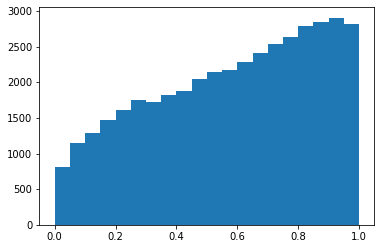

In [45]:
import matplotlib.pyplot as plt
plt.hist(P, bins = 20)

In [46]:
shortlisted_genes=[]
for i,p in enumerate(P):
    if(p<0.05):
        shortlisted_genes.append(i)

In [67]:
DNA_REPAIR=["ABL1","ALKBH1","APEX1","APTX","ASF1A","ATM","ATP23","ATR","ATRX","ATXN3","BLM","BRCA1","BRCA2","BTG2","CCNO","CDKN2D","CEBPG","CIB1","CSNK1D","CSNK1E","DDB1","DDB2","ERCC1","ERCC2","ERCC3","ERCC4","ERCC5","ERCC6","ERCC8","EXO1","FANCA","FANCC","FANCG","FEN1","GADD45A","GADD45G","GTF2H1","GTF2H4","HMGB1","HMGB1P10","HMGB2","HUS1","IGHMBP2","KAT5","LIG1","LIG3","LIG4","MLH1","MMS19","MNAT1","MPG","MRE11","MSH2","MSH3","MSH5","MSH6","MUTYH","NBN","NHEJ1","NTHL1","OGG1","PARP1","PARP3","PMS1","PMS2","PMS2P1","PNKP","POLA1","POLD1","POLE","POLE2","POLG","POLH","POLI","POLL","POLQ","PRKCG","RAD1","RAD17","RAD21","RAD23A","RAD23B","RAD50","RAD51","RAD51B","RAD51C","RAD52","RAD54B","RAD54L","RAD9A","RBBP8","RECQL","RECQL4","RECQL5","REV1","RFC3","RPA1","RPAIN","RUVBL2","SETX","SMC1A","SMUG1","SOD1","SUMO1","TDG","TNP1","TP53","TP73","TREX2","UBE2A","UBE2B","UBE2N","UBE2V1","UBE2V2","UNG","UPF1","UVRAG","VCP","WRNIP1","XAB2","XPC","XRCC2","XRCC3","XRCC4","XRCC6"]
FREE_RADICAL=["ADPRHL2","APOA4","ATP7A","BMP7","CCS","CD36","DHFR","DHFRP1","ERCC6","FANCC","FBLN5","GCH1","GLRX2","MIR21","MPO","MT3","NFE2L2","NOS3","NQO1","PARK7","PRDX1","PRDX2","RGN","SOD1","SOD2","SOD3","SZT2","TNF","TXNRD2","UCP2","UCP3"]
CYTOTOXICITY=["ARAF","BID","BRAF","CASP3","CD244","CD247","CD48","CHP1","CHP2","CSF2","FAS","FASLG","FCER1G","FCGR3A","FCGR3B","FYN","GRB2","GZMB","HCST","HLA-A","HLA-B","HLA-C","HLA-E","HLA-G","HRAS","ICAM1","ICAM2","IFNA1","IFNA10","IFNA13","IFNA14","IFNA16","IFNA17","IFNA2","IFNA21","IFNA4","IFNA5","IFNA6","IFNA7","IFNA8","IFNAR1","IFNAR2","IFNB1","IFNG","IFNGR1","IFNGR2","ITGAL","ITGB2","KIR2DL1","KIR2DL2","KIR2DL3","KIR2DL4","KIR2DL5A","KIR2DS1","KIR2DS3","KIR2DS4","KIR2DS5","KIR3DL1","KIR3DL2","KLRC1","KLRC2","KLRC3","KLRD1","KLRK1","KRAS","LAT","LCK","LCP2","MAP2K1","MAP2K2","MAPK1","MAPK3","MICA","MICB","NCR1","NCR2","NCR3","NFAT5","NFATC1","NFATC2","NFATC3","NFATC4","NRAS","PAK1","PIK3CA","PIK3CB","PIK3CD","PIK3CG","PIK3R1","PIK3R2","PIK3R3","PIK3R5","PLCG1","PLCG2","PPP3CA","PPP3CB","PPP3CC","PPP3R1","PPP3R2","PRF1","PRKCA","PRKCB","PRKCG","PTK2B","PTPN11","PTPN6","RAC1","RAC2","RAC3","RAET1E","RAET1G","RAET1L","RAF1","SH2D1A","SH2D1B","SH3BP2","SHC1","SHC2","SHC3","SHC4","SOS1","SOS2","SYK","TNF","TNFRSF10A","TNFRSF10B","TNFRSF10C","TNFRSF10D","TNFSF10","TYROBP","ULBP1","ULBP2","ULBP3","VAV1","VAV2","VAV3","ZAP70"]
XENOBIOTIC=["AADAC","ACAA1","ACSL1","ACSM1","ACSM2B","ACY1","ACY3","AHR","AHRR","AIP","AKR1C1","AKR7A2","AKR7A3","AKR7L","ALDH3A1","AOC1","AOC2","AOC3","ARNT","ARNT2","AS3MT","BCHE","BPHL","CBR3","CES1","CES2","CES3","CMBL","CRYZ","CYB5B","CYB5R3","CYP1A1","CYP1A2","CYP1B1","CYP26A1","CYP26B1","CYP2A13","CYP2A6","CYP2A7","CYP2B6","CYP2C18","CYP2C19","CYP2C8","CYP2C9","CYP2D6","CYP2D7","CYP2E1","CYP2F1","CYP2G1P","CYP2J2","CYP2R1","CYP2S1","CYP2U1","CYP2W1","CYP3A4","CYP3A5","CYP3A7","CYP46A1","DPEP1","EPHX1","EPHX2","FMO1","FMO2","FMO3","GGT1","GLYAT","GRIN1","GSTA4","GSTM1","GSTM2","GSTM3","GSTM4","GSTO1","GSTO2","GSTP1","HNF4A","HSP90AB1","LPO","MARC1","MARC2","MGST1","MGST2","MGST3","N6AMT1","NAT1","NAT2","NQO1","NQO2","NR1I2","PON3","POR","PTGES3","PTGS1","RORA","RORC","S100A12","STAR","SULT1A1","SULT1A2","SULT1A3","SULT1B1","UGT1A1","UGT1A10","UGT1A3","UGT1A4","UGT1A5","UGT1A6","UGT1A7","UGT1A8","UGT1A9","UGT2B11","UGT2B15","UGT2B28"]

dna_repair=[0 for i in range(4)]
free_radical=[0 for i in range(4)]
cytotoxicity=[0 for i in range(4)]
xenobiotic=[0 for i in range(4)]

for i in shortlisted_genes:
    Gene=df.iloc[i]['GeneSymbol']
    z=compute_gene_type(i)-1
    flag=False
    if Gene in DNA_REPAIR:
        dna_repair[z]+=1
        flag=True
    if Gene in FREE_RADICAL:
        free_radical[z]+=1
        flag=True
    if Gene in CYTOTOXICITY:
        cytotoxicity[z]+=1
        flag=True
    if Gene in XENOBIOTIC:
        xenobiotic[z]+=1
        flag=True
    if flag:
        pass

In [68]:
print(dna_repair)

[0, 0, 1, 0]


In [69]:
print(free_radical)

[0, 0, 0, 0]


In [70]:
print(cytotoxicity)

[1, 3, 1, 2]


In [71]:
print(xenobiotic)

[0, 3, 1, 2]


In [83]:
dna_repair=[0 for i in range(4)]
free_radical=[0 for i in range(4)]
cytotoxicity=[0 for i in range(4)]
xenobiotic=[0 for i in range(4)]


for i in shortlisted_genes:
    Gene=df.iloc[i]['GeneSymbol']
    z=compute_gene_type(i)
    flag=False
    
    if Gene in DNA_REPAIR:
        if z[0]!=-1:
            dna_repair[z[0]]+=1
        if z[1]!=-1:
            dna_repair[z[1]]+=1
        flag=True
    if Gene in FREE_RADICAL:
        if z[0]!=-1:
            free_radical[z[0]]+=1
        if z[1]!=-1:
            free_radical[z[1]]+=1
        flag=True
    if Gene in CYTOTOXICITY:
        if z[0]!=-1:
            cytotoxicity[z[0]]+=1
        if z[1]!=-1:
            cytotoxicity[z[1]]+=1
        flag=True
    if Gene in XENOBIOTIC:
        if z[0]!=-1:
            xenobiotic[z[0]]+=1
        if z[1]!=-1:
            xenobiotic[z[1]]+=1
        flag=True
    if flag:
        print(z)

print('Intersection Counts- Down in women, Up in women, Down in men, Up in women')
print("DNA Repair",dna_repair)
print("Free radical response",free_radical)
print("Natural killer cell cytotoxicity",cytotoxicity)
print("Xenobiotic Metabolism",xenobiotic)

[3, 0]
[3, 0]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[2, 1]
[3, 0]
[3, 0]
[2, 1]
[2, 1]
[3, 0]
[2, 1]
Intersection Counts- Down in women, Up in women, Down in men, Up in women
DNA Repair [0, 1, 1, 0]
Free radical response [0, 0, 0, 0]
Natural killer cell cytotoxicity [3, 4, 4, 3]
Xenobiotic Metabolism [2, 4, 4, 2]
